In [1]:
# from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

# splitting data:
from sklearn.model_selection import train_test_split
from sklearn import metrics

from scipy.stats import entropy

# web-based requests
import requests
import rapid_env

# Importing the os library specifically for reading the csv once I've created the file in my working directory.
import os

import acquire
import prepare


# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()

Imported env successfully.
credentials loaded successfully
End of acquire.py file.
Loaded all prepare functions.


# Plan

Data source is from Codeup's curriculum logs from January 2018 until October 2020. These logs track income IP addresses which are accessing the website's curriculum and possibly other areas of the website.

#### Objectives:
1. **Discover users who are accessing our curriculum pages way beyond the end of their codeup time.**
2. Give an example dataframe using the above criteria.
3. Use at least 1 time series method (such as Bollinger Bands) or measuring entropy to detect any anomalies.


#### Bonus:
1. Find and label students who are viewing both the web dev and data science curriculum.
2. Attempt to label individual students by their cohorts.
3. Label Students and Staff (Need to identify those two groups).
4. Label Zach, Maggie, Faith and Ryan's ids.


### Ideas:
- Try creating continuous variables from my categorical variables.
- Filter down the data to a specific cohort and looking at data that way to hopefully find something useful.
- Use as my attribute a single user id; loop through each user id. Then, *by user* find anomalies with regard to that *individual user*, not to the patterns across *all* users.
- Use this code to help create a categorical variable from continuous variables: `groupby().size() = continuous variable`
- *Nice to have:* to help me visualize, install an ip address library to map out where each ip address is.

In [2]:
colnames = ['date', 'timestamp', 'web_page', 'user_id', 'cohort_id', 'ip']

df = pd.read_csv('anonymized-curriculum-access.txt', engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0,1,2,3,4,5])
df

,date,timestamp,web_page,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
...,...,...,...,...,...,...
719454,2020-11-02,16:48:13,javascript-i/coffee-project,763,62.0,107.192.148.199
719455,2020-11-02,16:48:17,javascript-i/mapbox-api,771,62.0,172.125.226.175
719456,2020-11-02,16:48:18,javascript-i/coffee-project,771,62.0,172.125.226.175
719457,2020-11-02,16:48:28,javascript-i/bom-and-dom/bom,771,62.0,172.125.226.175


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719459 entries, 0 to 719458
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   date       719459 non-null  object 
 1   timestamp  719459 non-null  object 
 2   web_page   719458 non-null  object 
 3   user_id    719459 non-null  int64  
 4   cohort_id  674619 non-null  float64
 5   ip         719459 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 32.9+ MB


In [4]:
# pd.Timestamp.combine(df.date, df.timestamp)

In [5]:
df['date_time'] = df['date'] + " " + df["timestamp"]

In [6]:
df['date_time'] = pd.to_datetime(df.date_time)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719459 entries, 0 to 719458
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   date       719459 non-null  object        
 1   timestamp  719459 non-null  object        
 2   web_page   719458 non-null  object        
 3   user_id    719459 non-null  int64         
 4   cohort_id  674619 non-null  float64       
 5   ip         719459 non-null  object        
 6   date_time  719459 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 38.4+ MB


In [8]:
df = df.set_index('date_time')

In [9]:
df.drop(columns = ['date', 'timestamp'], inplace = True)
df.head()

,web_page,user_id,cohort_id,ip
date_time,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


#### Adding more columns that I'll need

In [10]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.month
df['weekday'] = df.index.day_name()
df['hour'] = df.index.hour
df

,web_page,user_id,cohort_id,ip,year,month,day,weekday,hour
date_time,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,2018,1,1,Friday,9
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,2018,1,1,Friday,9
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018,1,1,Friday,9
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,2018,1,1,Friday,9
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,2018,1,1,Friday,9
...,...,...,...,...,...,...,...,...,...
2020-11-02 16:48:13,javascript-i/coffee-project,763,62.0,107.192.148.199,2020,11,11,Monday,16
2020-11-02 16:48:17,javascript-i/mapbox-api,771,62.0,172.125.226.175,2020,11,11,Monday,16
2020-11-02 16:48:18,javascript-i/coffee-project,771,62.0,172.125.226.175,2020,11,11,Monday,16


In [11]:
df.index.value_counts()

2019-03-03 22:52:09    30
2019-03-03 22:52:07    30
2019-03-03 22:52:10    25
2019-03-03 22:52:11    25
2019-03-03 22:52:08    25
                       ..
2018-12-28 00:14:34     1
2019-10-03 13:42:14     1
2020-03-01 16:25:57     1
2020-07-28 08:57:20     1
2019-12-01 21:34:04     1
Name: date_time, Length: 688452, dtype: int64

#### Data Prepped.

# Explore

#### Questions I want to answer:
- Are there any users who are accessing the curriculum beyond the end of their codeup time?
- Are there any users who are accessing the data at odd hours?
- Can I find my own student id?
- Can I identify all student ids by cohort?

### Splitting into train/test

In [12]:
df.index.min(), df.index.max()

(Timestamp('2018-01-26 09:55:03'), Timestamp('2020-11-02 16:48:47'))

In [13]:
# Isolating down to a single cohort.

df.cohort_id.value_counts().sort_index()

1.0      8884
2.0        93
4.0         4
5.0         1
6.0        72
7.0       495
8.0      1712
9.0         5
11.0      208
12.0      302
13.0     2733
14.0     9495
15.0      691
16.0      743
17.0     4925
18.0     2005
19.0     1165
21.0     7444
22.0    30328
23.0    28329
24.0    35624
25.0    25427
26.0    27637
27.0    20447
28.0    60315
29.0    37548
31.0    25253
32.0    28333
33.0    40168
34.0    25181
51.0    29688
52.0    27518
53.0    36047
55.0    20411
56.0    31670
57.0    32447
58.0    28354
59.0    22425
61.0    11774
62.0     8718
Name: cohort_id, dtype: int64

In [14]:
df[df['cohort_id'] == 59.0]

,web_page,user_id,cohort_id,ip,year,month,day,weekday,hour
date_time,,,,,,,,,
2020-07-13 14:34:44,/,678,59.0,76.201.20.193,2020,7,7,Monday,14
2020-07-13 14:37:22,/,679,59.0,24.28.146.155,2020,7,7,Monday,14
2020-07-13 14:38:28,/,680,59.0,136.50.56.155,2020,7,7,Monday,14
2020-07-13 14:39:21,13-advanced-topics/1-tidy-data,679,59.0,24.28.146.155,2020,7,7,Monday,14
2020-07-13 14:39:36,1-fundamentals/1.1-intro-to-data-science,679,59.0,24.28.146.155,2020,7,7,Monday,14
...,...,...,...,...,...,...,...,...,...
2020-11-02 15:47:59,appendix/useful_libraries,698,59.0,24.28.150.196,2020,11,11,Monday,15
2020-11-02 15:48:03,appendix/ds-environment-setup,698,59.0,24.28.150.196,2020,11,11,Monday,15
2020-11-02 15:48:14,appendix/interview_questions_students,698,59.0,24.28.150.196,2020,11,11,Monday,15


In [15]:
# Can I find the start date by cohort id? Yes
# Can I find the darden cohort? The target start date would be 7-13-2020:

darden = df[df['cohort_id'] == 59.0]

darden

,web_page,user_id,cohort_id,ip,year,month,day,weekday,hour
date_time,,,,,,,,,
2020-07-13 14:34:44,/,678,59.0,76.201.20.193,2020,7,7,Monday,14
2020-07-13 14:37:22,/,679,59.0,24.28.146.155,2020,7,7,Monday,14
2020-07-13 14:38:28,/,680,59.0,136.50.56.155,2020,7,7,Monday,14
2020-07-13 14:39:21,13-advanced-topics/1-tidy-data,679,59.0,24.28.146.155,2020,7,7,Monday,14
2020-07-13 14:39:36,1-fundamentals/1.1-intro-to-data-science,679,59.0,24.28.146.155,2020,7,7,Monday,14
...,...,...,...,...,...,...,...,...,...
2020-11-02 15:47:59,appendix/useful_libraries,698,59.0,24.28.150.196,2020,11,11,Monday,15
2020-11-02 15:48:03,appendix/ds-environment-setup,698,59.0,24.28.150.196,2020,11,11,Monday,15
2020-11-02 15:48:14,appendix/interview_questions_students,698,59.0,24.28.150.196,2020,11,11,Monday,15


#### Takeaways:

- Darden's cohort appears to be cohort id 59.0 because the first date anyone from that cohort accessed the database was on July 13th, 2020.
- Now, I'm going to calculate the number of users within the cohort over time...

In [16]:
# This prints out the start date of the cohort to the most recent date we have data for.
print("Cohort dates were from", df[df['cohort_id'] == 59.0].index.min(), "thru", df[df['cohort_id'] == 59.0].index.max())


Cohort dates were from 2020-07-13 14:34:44 thru 2020-11-02 15:52:23


In [17]:
# What questions now?
# How many users were in the start of the cohort?

darden['2020-11-02'].web_page.value_counts()

timeseries/modeling-lesson1                               22
classification/scale_features_or_not.svg                  19
classification/overview                                   18
/                                                         17
anomaly-detection/overview                                12
anomaly-detection/AnomalyDetectionCartoon.jpeg            12
timeseries/modeling-lesson2                               11
timeseries/working-with-time-series-data                   8
timeseries/project                                         7
timeseries/explore                                         5
timeseries/prep                                            4
search/search_index.json                                   3
timeseries/sarimax                                         2
appendix/useful_libraries                                  2
timeseries/working-with-time-series-data-with-pandas       2
timeseries/svr                                             2
timeseries/acquire      

In [18]:
(darden['2020-11-02']['web_page'] == 'python/advanced-dataframes').count()

169

In [19]:
df

,web_page,user_id,cohort_id,ip,year,month,day,weekday,hour
date_time,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,2018,1,1,Friday,9
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,2018,1,1,Friday,9
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018,1,1,Friday,9
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,2018,1,1,Friday,9
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,2018,1,1,Friday,9
...,...,...,...,...,...,...,...,...,...
2020-11-02 16:48:13,javascript-i/coffee-project,763,62.0,107.192.148.199,2020,11,11,Monday,16
2020-11-02 16:48:17,javascript-i/mapbox-api,771,62.0,172.125.226.175,2020,11,11,Monday,16
2020-11-02 16:48:18,javascript-i/coffee-project,771,62.0,172.125.226.175,2020,11,11,Monday,16


In [20]:
print(df.groupby(['user_id', 'cohort_id']).size())

user_id  cohort_id
1        8.0          1617
         28.0         4823
2        22.0         1541
3        22.0         1562
4        22.0          692
                      ... 
783      59.0           54
784      61.0           93
785      59.0           31
786      56.0            7
787      55.0            1
Length: 748, dtype: int64


## Isolating my own user ID

In [21]:
my_ip = '96.8.130.213'

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 719459 entries, 2018-01-26 09:55:03 to 2020-11-02 16:48:47
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   web_page   719458 non-null  object 
 1   user_id    719459 non-null  int64  
 2   cohort_id  674619 non-null  float64
 3   ip         719459 non-null  object 
 4   year       719459 non-null  int64  
 5   month      719459 non-null  int64  
 6   day        719459 non-null  int64  
 7   weekday    719459 non-null  object 
 8   hour       719459 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 54.9+ MB


In [22]:
(df.ip == my_ip).value_counts()

False    719248
True        211
Name: ip, dtype: int64

In [23]:
# (darden['2020-11-02']['web_page'] == 'python/advanced-dataframes').count()

df[df.ip == my_ip]

,web_page,user_id,cohort_id,ip,year,month,day,weekday,hour
date_time,,,,,,,,,
2020-10-06 09:42:04,timeseries/project,692,59.0,96.8.130.213,2020,10,10,Tuesday,9
2020-10-06 09:42:21,clustering/project,692,59.0,96.8.130.213,2020,10,10,Tuesday,9
2020-10-06 09:42:27,timeseries/project,692,59.0,96.8.130.213,2020,10,10,Tuesday,9
2020-10-06 12:53:17,regression/model,692,59.0,96.8.130.213,2020,10,10,Tuesday,12
2020-10-06 15:13:50,sql/mysql-overview,692,59.0,96.8.130.213,2020,10,10,Tuesday,15
...,...,...,...,...,...,...,...,...,...
2020-10-29 14:39:19,timeseries/working-with-time-series-data,692,59.0,96.8.130.213,2020,10,10,Thursday,14
2020-10-30 09:45:51,timeseries/modeling-lesson1,692,59.0,96.8.130.213,2020,10,10,Friday,9
2020-10-30 17:01:12,timeseries/explore,692,59.0,96.8.130.213,2020,10,10,Friday,17


In [24]:
df[df.user_id == 692].index.min()

Timestamp('2020-07-13 14:45:01')

In [25]:
df[df.user_id == 692].index.max()

Timestamp('2020-11-02 10:19:25')

In [26]:
my_pings = df[df.user_id == 692]

In [27]:
my_pings['2020-11-02']

,web_page,user_id,cohort_id,ip,year,month,day,weekday,hour
date_time,,,,,,,,,
2020-11-02 10:19:14,timeseries/prep,692,59.0,96.8.130.213,2020,11,11,Monday,10
2020-11-02 10:19:25,timeseries/working-with-time-series-data,692,59.0,96.8.130.213,2020,11,11,Monday,10


In [28]:
# Ok, so now I've found my ip address, my cohort, and my user id.
# user id = 692

In [29]:
# Checking for any null values in the df:
my_pings.isnull().sum()

web_page     0
user_id      0
cohort_id    0
ip           0
year         0
month        0
day          0
weekday      0
hour         0
dtype: int64

In [30]:
my_pings.resample("D").size()

date_time
2020-07-13      4
2020-07-14    112
2020-07-15      9
2020-07-16     53
2020-07-17     12
             ... 
2020-10-29      4
2020-10-30      2
2020-10-31      0
2020-11-01      0
2020-11-02      2
Freq: D, Length: 113, dtype: int64

In [31]:
my_pings = pd.DataFrame(my_pings.groupby(['web_page', 'cohort_id']).resample("D").size())

In [32]:
my_pings

0
web_page                                 cohort_id date_time    
/                                        59.0      2020-07-13  1
                                                   2020-07-14  2
                                                   2020-07-15  0
                                                   2020-07-16  1
                                                   2020-07-17  1
...                                                           ..
timeseries/working-with-time-series-data 59.0      2020-10-30  0
                                                   2020-10-31  0
                                                   2020-11-01  0
                                                   2020-11-02  1
working-with-time-series-data            59.0      2020-10-24  2

[3003 rows x 1 columns]

In [33]:
my_pings = my_pings.reset_index().set_index("date_time")
my_pings

,web_page,cohort_id,0
date_time,,,
2020-07-13,/,59.0,1
2020-07-14,/,59.0,2
2020-07-15,/,59.0,0
2020-07-16,/,59.0,1
2020-07-17,/,59.0,1
...,...,...,...
2020-10-30,timeseries/working-with-time-series-data,59.0,0
2020-10-31,timeseries/working-with-time-series-data,59.0,0
2020-11-01,timeseries/working-with-time-series-data,59.0,0


In [34]:
my_pings.rename(columns = {0:'hits'}, inplace = True)
my_pings

,web_page,cohort_id,hits
date_time,,,
2020-07-13,/,59.0,1
2020-07-14,/,59.0,2
2020-07-15,/,59.0,0
2020-07-16,/,59.0,1
2020-07-17,/,59.0,1
...,...,...,...
2020-10-30,timeseries/working-with-time-series-data,59.0,0
2020-10-31,timeseries/working-with-time-series-data,59.0,0
2020-11-01,timeseries/working-with-time-series-data,59.0,0


In [35]:
# Reduce my Df down to daily, .sum() only using date_time and hits.
my_hits = my_pings.copy()
my_hits.drop(columns = ['web_page', 'cohort_id'], inplace = True)
my_hits

,hits
date_time,
2020-07-13,1
2020-07-14,2
2020-07-15,0
2020-07-16,1
2020-07-17,1
...,...
2020-10-30,0
2020-10-31,0
2020-11-01,0


In [36]:
my_hits = my_hits.resample("D").sum()

<AxesSubplot:xlabel='date_time'>

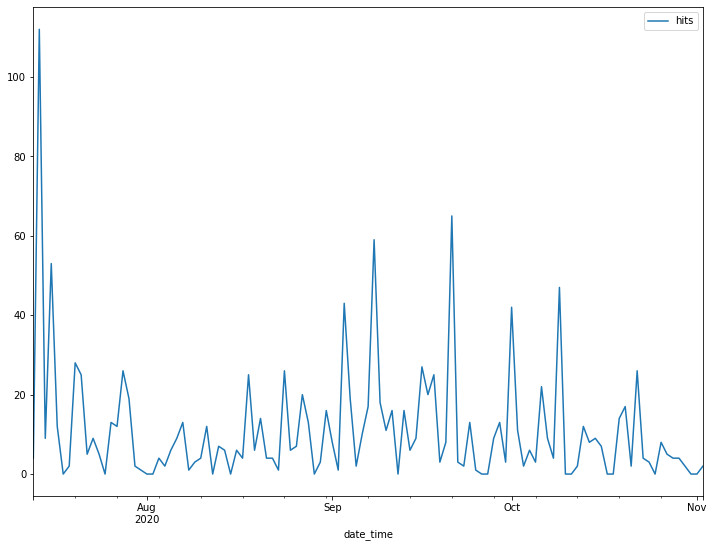

In [37]:
my_hits.plot(figsize = (12, 9))

### SMA

<AxesSubplot:xlabel='date_time'>

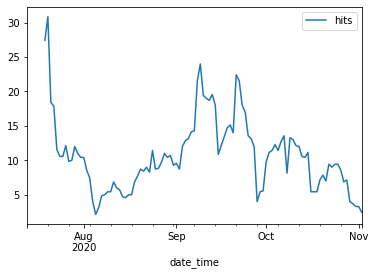

In [38]:
short_sma = my_hits.rolling(window = 7).mean()
short_sma.plot()

<AxesSubplot:xlabel='date_time'>

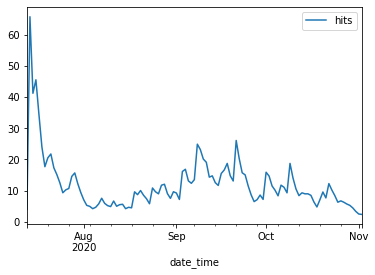

In [39]:
short_ema = my_hits.ewm(span = 7).mean()
short_ema.plot()

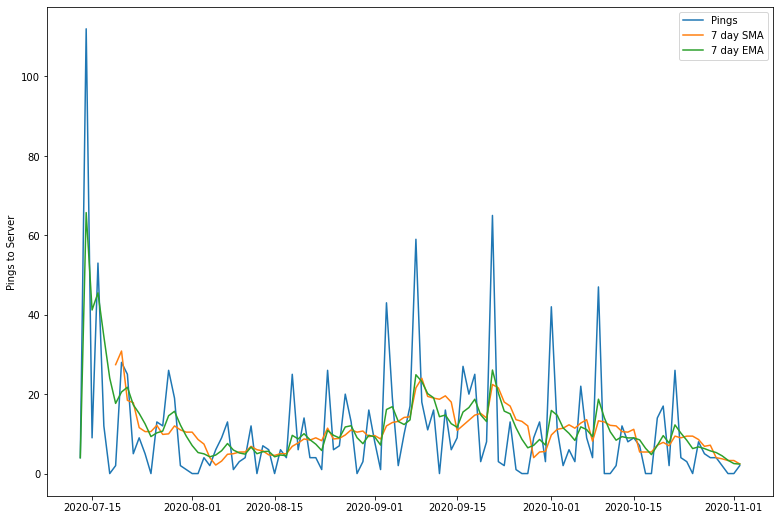

In [40]:
# Plotting user 692's ping count and the 7-day SMA and EMA:

fig, ax = plt.subplots(figsize = (13, 9))

ax.plot(my_hits.index, my_hits, label = 'Pings')

ax.plot(my_hits.index, short_sma, label = '7 day SMA')

ax.plot(my_hits.index, short_ema, label = '7 day EMA')

ax.legend(loc = 'best')
ax.set_ylabel("Pings to Server")
plt.show()

### Creating the Bollinger Bands:

In [41]:
# Setting time interval:
span = 30

# BBand mid-band:

midband = my_hits.ewm(span = span).mean()


stdev = my_hits.ewm(span = span).std()
stdev

,hits
date_time,
2020-07-13,NaN
2020-07-14,76.367532
2020-07-15,60.888078
2020-07-16,49.215806
2020-07-17,44.633402
...,...
2020-10-29,10.538946
2020-10-30,10.312936
2020-10-31,10.166485


In [42]:
upband = midband + (stdev * 1.5)
lowband = midband - (stdev * 1.5)

upband

,hits
date_time,
2020-07-13,NaN
2020-07-14,174.351299
2020-07-15,133.057774
2020-07-16,118.655859
2020-07-17,104.312143
...,...
2020-10-29,24.080889
2020-10-30,23.336936
2020-10-31,22.609367


Adding the Bollinger Bands to the chart:

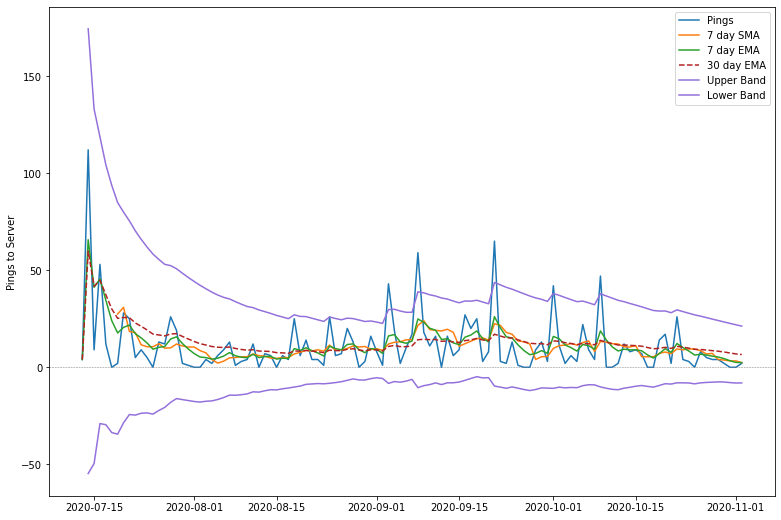

In [43]:
# Plotting user 692's ping count and the 7-day SMA and EMA:

fig, ax = plt.subplots(figsize = (13, 9))

ax.plot(my_hits.index, my_hits, label = 'Pings')
ax.plot(my_hits.index, short_sma, label = '7 day SMA')
ax.plot(my_hits.index, short_ema, label = '7 day EMA')

# Bollinger Bands section:
ax.plot(my_hits.index, midband, label = '30 day EMA', c = 'firebrick', linestyle = "--", linewidth = 1.5)
ax.plot(my_hits.index, upband, label = 'Upper Band', c = 'mediumpurple')
ax.plot(my_hits.index, lowband, label = 'Lower Band', c = 'mediumpurple')



ax.axhline(linewidth = .5, c = 'grey', linestyle = "--") # dashed line showing the 0 point. Since there can't be negative number of pings, I feel I need a way to set the lowest boundary visually.
ax.legend(loc = 'best')
ax.set_ylabel("Pings to Server")
plt.show()

In [44]:
my_hits.head()

,hits
date_time,
2020-07-13,4
2020-07-14,112
2020-07-15,9
2020-07-16,53
2020-07-17,12


In [45]:
# I'll need to either concat or merge (probably concat) Midband, upband and low band onto this df so that I can chart it...
my_hits_plot = my_hits.copy()
my_hits_plot = pd.merge(my_hits_plot, upband, left_index = True, right_index = True)
my_hits_plot['midband'] = my_hits.ewm(span = span).mean()
my_hits_plot = pd.merge(my_hits_plot, lowband, left_index = True, right_index = True)

# Renaming the columns:

my_hits_plot.columns = ['hits', 'upperband', 'midband', 'lowerband']

my_hits_plot

,hits,upperband,midband,lowerband
date_time,,,,
2020-07-13,4,NaN,4.000000,NaN
2020-07-14,112,174.351299,59.800000,-54.751299
2020-07-15,9,133.057774,41.725657,-49.606460
2020-07-16,53,118.655859,44.832149,-28.991560
2020-07-17,12,104.312143,37.362041,-29.588062
...,...,...,...,...
2020-10-29,4,24.080889,8.272471,-7.535948
2020-10-30,2,23.336936,7.867531,-7.601873
2020-10-31,0,22.609367,7.359639,-7.890089


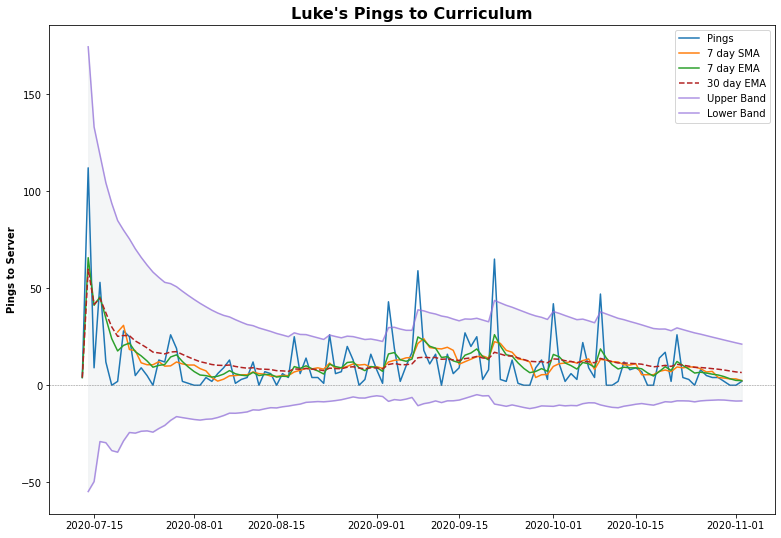

In [46]:
# # plt.style.use('fivethirtyeight')
# fig = plt.figure(figsize = (18, 10))
# ax = fig.add_subplot(111)
# x_axis = spx_small.index.get_level_values(0)

# ax.fill_between(x_axis, spx_small['upper_band'], spx_small['lower_band'], color = 'slategrey', alpha = .25)

# ax.plot(x_axis, spx_small['spx'], color = 'blue', linewidth = '1.05')
# ax.plot(x_axis, spx_small['20_day_ma'], color = 'orange', alpha = .91)

# plt.show()

# --------------------------------------

# Plotting user 692's ping count and the 7-day SMA and EMA:

fig, ax = plt.subplots(figsize = (13, 9))

ax.plot(my_hits_plot.index, my_hits_plot.hits, label = 'Pings')
ax.plot(my_hits_plot.index, short_sma, label = '7 day SMA')
ax.plot(my_hits_plot.index, short_ema, label = '7 day EMA')

# Bollinger Bands section:
ax.plot(my_hits_plot.index, midband, label = '30 day EMA', c = 'firebrick', linestyle = "--", linewidth = 1.5)
ax.plot(my_hits_plot.index, upband, label = 'Upper Band', c = 'mediumpurple', alpha = .75)
ax.plot(my_hits_plot.index, lowband, label = 'Lower Band', c = 'mediumpurple', alpha = .75)

# Filling between the BBands:
x_axis = my_hits_plot.index.get_level_values(0)
ax.fill_between(x = x_axis, y1 = my_hits_plot.upperband, y2 = my_hits_plot.lowerband, color = 'slategrey', alpha = .07)


# Plotting the 0 line and setting up the legend, Title and labels, etc.
ax.axhline(linewidth = .5, c = 'grey', linestyle = "--") # dashed line showing the 0 point. Since there can't be negative number of pings, I feel I need a way to set the lowest boundary visually.
ax.legend(loc = 'best')
ax.set_title("Luke's Pings to Curriculum", fontsize = 16, fontweight = 'bold')
ax.set_ylabel("Pings to Server", fontweight = 'bold')
plt.show()

### Computing Entropy

In [47]:
def compute_entropy(series):
    counts = series.value_counts()
    if len(counts)==1:
        ent = 0
    else:
        value, counts = np.unique(series, return_counts=True)
        ent = entropy(counts, base=None)
    return ent

In [48]:
compute_entropy(df.ip)

4.281933437860451

In [49]:
compute_entropy(df.user_id)

6.170031470548415

In [50]:
compute_entropy(df.cohort_id)

3.9027926786187983

### Search for IPs
- 

In [51]:
import requests

url = "https://free-geo-ip.p.rapidapi.com/xml/96.8.130.213"

headers = {
    'x-rapidapi-key': "671e72ff8dmsh51958d0b0f05f16p143064jsn9c149f8d2f3e",
    'x-rapidapi-host': "free-geo-ip.p.rapidapi.com"
    }

response = requests.request("GET", url, headers=headers)

print(response.text)

<Response>
	<IP>96.8.130.213</IP>
	<CountryCode>US</CountryCode>
	<CountryName>United States</CountryName>
	<RegionCode>TX</RegionCode>
	<RegionName>Texas</RegionName>
	<City>San Antonio</City>
	<ZipCode>78260</ZipCode>
	<TimeZone>America/Chicago</TimeZone>
	<Latitude>29.7026</Latitude>
	<Longitude>-98.4759</Longitude>
	<MetroCode>641</MetroCode>
</Response>



In [52]:
import rapid_env

In [53]:
url = "https://free-geo-ip.p.rapidapi.com/xml/96.8.130.213"

headers = {
    'x-rapidapi-key': rapid_env.my_key,
    'x-rapidapi-host': rapid_env.host
    }

response = requests.request("GET", url, headers=headers)

print(response.text)

<Response>
	<IP>96.8.130.213</IP>
	<CountryCode>US</CountryCode>
	<CountryName>United States</CountryName>
	<RegionCode>TX</RegionCode>
	<RegionName>Texas</RegionName>
	<City>San Antonio</City>
	<ZipCode>78260</ZipCode>
	<TimeZone>America/Chicago</TimeZone>
	<Latitude>29.7026</Latitude>
	<Longitude>-98.4759</Longitude>
	<MetroCode>641</MetroCode>
</Response>



In [54]:
print(rapid_env.my_key)

671e72ff8dmsh51958d0b0f05f16p143064jsn9c149f8d2f3e


In [55]:
type(rapid_env.my_key)

str

In [56]:
df_cohort = df[['cohort_id']]

In [57]:
train = df_cohort[:'2019-10-17']
validate = df_cohort['2019-10-18':'2020-05-15']
test = df_cohort['2020-05-16':]

In [58]:
train.shape, validate.shape, test.shape

((374666, 1), (169299, 1), (175494, 1))

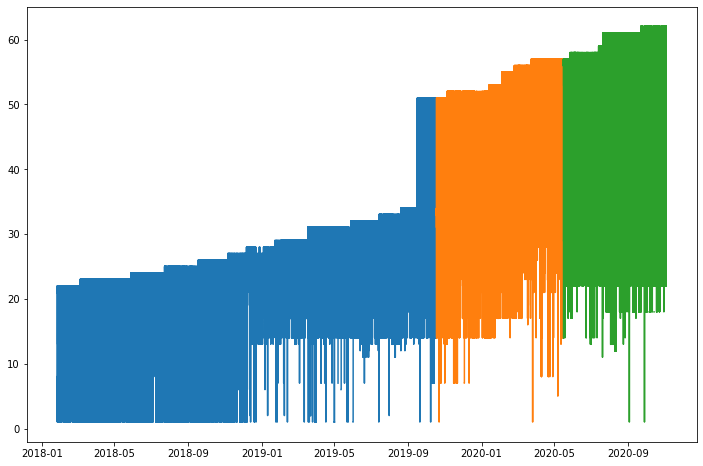

In [59]:
plt.figure(figsize=(12, 8))
plt.plot(train)
plt.plot(validate)
plt.plot(test)
plt.show()

In [60]:
mask = (df.column.str.contains(“A”) | df.column.str.contains(“B”))
df[mask]

SyntaxError: invalid character in identifier (<ipython-input-60-a53dc647fea2>, line 1)

In [ ]:
# my_datetime_fmt = mdates.DateFormatter('%m-%d %H:%T')

# df_ts_size = df['user_id'].resample('30T').count()

# idx = pd.date_range(
#     df_ts_size.sort_index().index.min(), 
#     df_ts_size.sort_index().index.max(),
#     freq='30min'
# )

# df_ts_size = df_ts_size.reindex(idx, fill_value=0).fillna(value=0)

# # , 'cohort_id', 'ip', 'year', 'month', 'day', 'weekday', 'hour'

In [ ]:
# start_date_train = df.head(1).index[0]
# end_date_train = '2019-12-31 23:30:00'
# start_date_test = '2020-01-01 00:00:00'

# train = df_ts_size[:end_date_train]
# test = df_ts_size[start_date_test:]

# plt.figure(figsize=(12, 8))
# plt.plot(train)
# plt.plot(test)
# plt.show()

In [ ]:
train1.head()

<AxesSubplot:xlabel='date_time'>

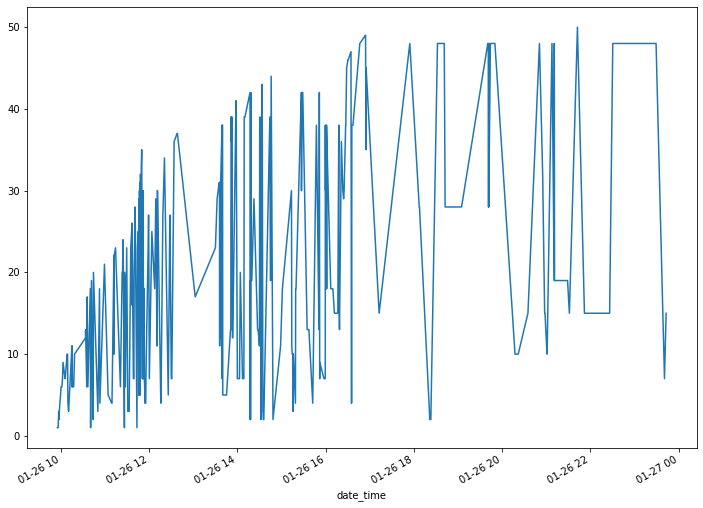

In [61]:
# Creating a quick plot of the user_id column for one day to get my bearings.

df['2018-01-26'].user_id.plot(figsize = (12, 9))

In [63]:
df.head()

,web_page,user_id,cohort_id,ip,year,month,day,weekday,hour
date_time,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,2018,1,1,Friday,9
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,2018,1,1,Friday,9
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018,1,1,Friday,9
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,2018,1,1,Friday,9
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,2018,1,1,Friday,9


<AxesSubplot:xlabel='hour', ylabel='cohort_id'>

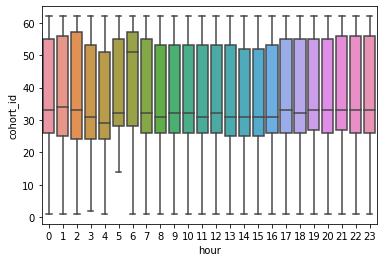

In [62]:
sns.boxplot(data = df, x = 'hour', y = 'cohort_id')

#### Takeaways:

- The user id column has the highest entropy compared to the other columns tested here, but that doesn't necessarily mean there is a high level of entropy on an objective level. Subjectively, user id is higher, but that's also possible because there is more unique entries in that column than the other columns tested.
- Going to look more deeply into user id.

In [ ]:
sns.boxplot(data)

In [ ]:
# df.columns = [' '.join(col).strip() for col in df.columns.values]